In [53]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import string
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, Dropout
import keras_tuner as kt
from keras.metrics import Accuracy
from keras import utils
from keras import callbacks
from absl import logging

In [6]:
DATA_PATH_TRAIN = '../data/raw/train.csv'
DATA_PATH_TEST  = '../data/raw/test.csv'

# Helper functions

# Read data

In [7]:
df_train = pd.read_csv(DATA_PATH_TRAIN)
df_test = pd.read_csv(DATA_PATH_TEST)

In [8]:
display(df_train.head(), df_test.head())

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative


# EDA

In [9]:
df_train.shape, df_test.shape

((40000, 2), (10000, 2))

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [11]:
df_train.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [12]:
df_train.sentiment.value_counts()

sentiment
positive    20000
negative    20000
Name: count, dtype: int64

In [13]:
df_test.sentiment.value_counts()

sentiment
negative    5000
positive    5000
Name: count, dtype: int64

## Check for duplicates

In [14]:
duplicated_df_train = df_train[df_train.duplicated()]
duplicated_df_test  = df_test[df_test.duplicated()]
display(duplicated_df_train.shape, duplicated_df_train, duplicated_df_test.shape, duplicated_df_test)

(272, 2)

,review,sentiment
1700,There are plenty of comments already posted sa...,negative
2062,No one would ever question that director Leos ...,positive
2659,Well I guess I know the answer to that questio...,negative
3540,There's something frustrating about watching a...,negative
4176,Do we really need any more narcissistic garbag...,negative
...,...,...
39722,"Yep, this has got to be one of the lamest movi...",negative
39738,Inappropriate. The PG rating that this movie g...,negative
39803,"Les Visiteurs, the first movie about the medie...",negative
39926,This film is so bad and gets worse in every im...,negative


(13, 2)

,review,sentiment
1899,The scenes are fast-paced. the characters are ...,positive
2964,I've tried to reconcile why so many bad review...,positive
3068,What a clunker!<br /><br />It MUST have been m...,negative
3266,The daytime TV of films. Seldom have I felt so...,negative
4624,"Pretentious claptrap, updating Herman Melville...",negative
6026,"well, the writing was very sloppy, the directi...",negative
6990,"Hilarious, clean, light-hearted, and quote-wor...",positive
7524,What can I say? An excellent end to an excelle...,positive
8167,"What a shocker. For starters, I couldn't stand...",negative
8911,Since I am required to write minimum of 10 lin...,negative


There are some duplicates in train and test data, I'll delete them.

In [15]:
df_train = df_train.drop_duplicates()
df_test  = df_test.drop_duplicates()

In [16]:
df_train.shape, df_test.shape

((39728, 2), (9987, 2))

## Check missing values

In [17]:
df_train.isna().sum()

review       0
sentiment    0
dtype: int64

In [18]:
df_test.isna().sum()

review       0
sentiment    0
dtype: int64

There are no missing values in both sets.

## Sentiment Distribution Analysis

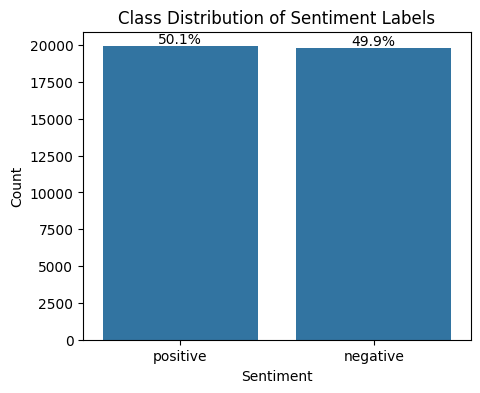

In [19]:
# Plotting the sentiment distribution

plt.figure(figsize = (5, 4))
ax = sns.countplot(x = 'sentiment', data = df_train, order = df_train['sentiment'].value_counts().index)
plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha = 'center', va = 'bottom')
plt.show()

 The dataset contains an almost equal distribution between positive and negative sentiments.

In [20]:
# Displaying class distribution and summary of text length

df_train['text_length'] = df_train['review'].apply(len)
display(df_train['sentiment'].value_counts(), df_train['text_length'].describe())

sentiment
positive    19923
negative    19805
Name: count, dtype: int64

count    39728.000000
mean      1311.359469
std        988.798970
min         41.000000
25%        699.000000
50%        971.500000
75%       1596.000000
max      13704.000000
Name: text_length, dtype: float64

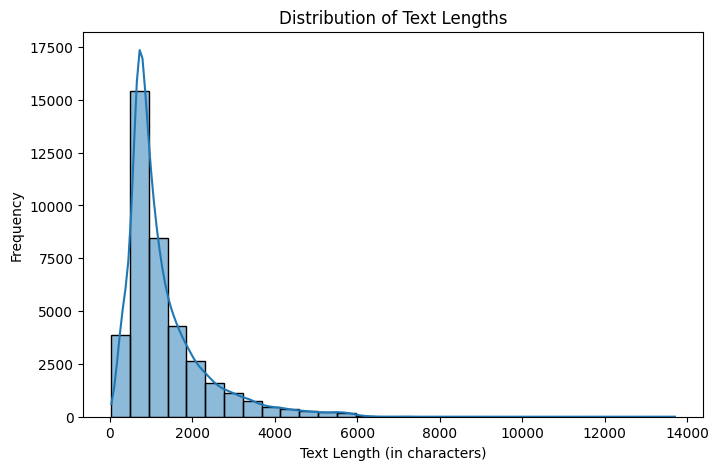

In [21]:
# Plotting the distribution of text lengths

plt.figure(figsize = (8, 5))
sns.histplot(df_train['text_length'], bins = 30, kde = True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.show()

Most texts fall within the range of 700 to 1500 characters, with the average length being 1311 characters.

**Summary of Key Insights:**

1. Sentiment Class Distribution:
  - There are almost the same number of positive and negative labels.
2. Text Length Distribution:
  - The average length of texts is about 1311 characters.
  - The most common text lengths range between 700 and 1500 characters, with a drop off towards the end of the distribution.
  - The maximum length of texts in the data set is 13704 characters.

# Processing Text Data

## Text cleaning

In [22]:
df_train_processed = df_train.copy()

In [23]:
df_train_processed.drop('text_length', axis = 1, inplace = True)

# Converting to lowercase
df_train_processed = df_train_processed.map(lambda x: x.lower() if isinstance(x, str) else x)

In [24]:
df_train_processed.head()

,review,sentiment
0,i caught this little gem totally by accident b...,positive
1,i can't believe that i let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,if there's one thing i've learnt from watching...,negative
4,"i remember when this was in theaters, reviews ...",negative


In [25]:
# Removing remove non-word and non-whitespace characters
df_train_processed = df_train_processed.replace(to_replace = r'[^\w\s]', value = '', regex = True)

In [26]:
df_train_processed.head()

,review,sentiment
0,i caught this little gem totally by accident b...,positive
1,i cant believe that i let myself into this mov...,negative
2,spoiler alert it just gets to me the nerve som...,negative
3,if theres one thing ive learnt from watching g...,negative
4,i remember when this was in theaters reviews s...,negative


In [27]:
# Removing digits
df_train_processed = df_train_processed.replace(to_replace = r'\d', value = '', regex = True)

## Tokenization

In [33]:
# Download necessary resources for tokenization and stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [30]:
# Apply tokenization
df_train_processed['review'] = df_train_processed['review'].apply(word_tokenize)

In [32]:
df_train_processed.head()

,review,sentiment
0,"[i, caught, this, little, gem, totally, by, ac...",positive
1,"[i, cant, believe, that, i, let, myself, into,...",negative
2,"[spoiler, alert, it, just, gets, to, me, the, ...",negative
3,"[if, theres, one, thing, ive, learnt, from, wa...",negative
4,"[i, remember, when, this, was, in, theaters, r...",negative


## Stopword Removal

In [34]:
stop_words = set(stopwords.words('english'))
df_train_processed['review'] = df_train_processed['review'].apply(lambda x: [word for word in x if word not in stop_words])

In [35]:
df_train_processed

,review,sentiment
0,"[caught, little, gem, totally, accident, back,...",positive
1,"[cant, believe, let, movie, accomplish, favor,...",negative
2,"[spoiler, alert, gets, nerve, people, remake, ...",negative
3,"[theres, one, thing, ive, learnt, watching, ge...",negative
4,"[remember, theaters, reviews, said, horrible, ...",negative
...,...,...
39995,"[man, named, walt, disney, mission, satisfy, f...",positive
39996,"[first, time, saw, shades, sneakpreview, hadnt...",negative
39997,"[waste, time, danger, watch, tempted, tear, dv...",negative
39998,"[far, pathetic, movie, indian, cinema, cinema,...",negative


## Stemming and Lemmatization

Stemming is a simple and practical approach that involves cutting off the ends of words with the intention of obtaining the correct root form.
Lemmatization aims to remove inflectional endings only and to return the base or dictionary form of a word, which is known as 'lemma'. 

In [36]:
# Initialize the Snowball Stemmer
stemmer = SnowballStemmer('english')

# Define a function to perform stemming on the 'review' column
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# Apply the function to the 'review' column and create a new column 'stemmed_review'
df_train_processed['stemmed_review'] = df_train_processed['review'].apply(stem_words)

In [38]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization on the 'review' column
def lem_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

# Apply the function to the 'review' column and create a new column 'lemmatized_review'
df_train_processed['lemmatized_review'] = df_train_processed['review'].apply(lem_words)

In [39]:
df_train_processed

,review,sentiment,stemmed_review,lemmatized_review
0,"[caught, little, gem, totally, accident, back,...",positive,"[caught, littl, gem, total, accid, back, reviv...","[caught, little, gem, totally, accident, back,..."
1,"[cant, believe, let, movie, accomplish, favor,...",negative,"[cant, believ, let, movi, accomplish, favor, f...","[cant, believe, let, movie, accomplish, favor,..."
2,"[spoiler, alert, gets, nerve, people, remake, ...",negative,"[spoiler, alert, get, nerv, peopl, remak, use,...","[spoiler, alert, get, nerve, people, remake, u..."
3,"[theres, one, thing, ive, learnt, watching, ge...",negative,"[there, one, thing, ive, learnt, watch, georg,...","[there, one, thing, ive, learnt, watching, geo..."
4,"[remember, theaters, reviews, said, horrible, ...",negative,"[rememb, theater, review, said, horribl, well,...","[remember, theater, review, said, horrible, we..."
...,...,...,...,...
39995,"[man, named, walt, disney, mission, satisfy, f...",positive,"[man, name, walt, disney, mission, satisfi, fa...","[man, named, walt, disney, mission, satisfy, f..."
39996,"[first, time, saw, shades, sneakpreview, hadnt...",negative,"[first, time, saw, shade, sneakpreview, hadnt,...","[first, time, saw, shade, sneakpreview, hadnt,..."
39997,"[waste, time, danger, watch, tempted, tear, dv...",negative,"[wast, time, danger, watch, tempt, tear, dvd, ...","[waste, time, danger, watch, tempted, tear, dv..."
39998,"[far, pathetic, movie, indian, cinema, cinema,...",negative,"[far, pathet, movi, indian, cinema, cinema, co...","[far, pathetic, movie, indian, cinema, cinema,..."


While building models, I will use stemmed and lemitized data separately, and then compare both approaches.

## Vectorization

### Bag of Words (BoW)

The Bag of Words model represents text by converting it into a collection of words (or tokens) and their frequencies, disregarding grammar, word order, and context. Each document is represented as a vector of word counts, with each element in the vector corresponding to the frequency of a specific word in the document.

In [64]:
# Convert tokenized data back to text for vectorizers
df_train_processed['stemmed_text']    = df_train_processed['stemmed_review'].apply(lambda x: ' '.join(x))
df_train_processed['lemmatized_text'] = df_train_processed['lemmatized_review'].apply(lambda x: ' '.join(x))

# Create separate vectorizers for stemmed and lemmatized data
vectorizer_bow_stemmed = CountVectorizer(max_features=5000) 
vectorizer_bow_lemmatized = CountVectorizer(max_features=5000)

# Fit and transform
X_bow_stemmed = vectorizer_bow_stemmed.fit_transform(df_train_processed['stemmed_text'])
X_bow_lemmatized = vectorizer_bow_lemmatized.fit_transform(df_train_processed['lemmatized_text'])

#bow_stemmed_df = pd.DataFrame(X_bow_stemmed.toarray(), columns = vectorizer_bow_stemmed.get_feature_names_out())
#bow_lemmatized_df = pd.DataFrame(X_bow_lemmatized.toarray(), columns = vectorizer_bow_lemmatized.get_feature_names_out())

In [68]:
print("Bag of Words - Stemmed:")
print(f"Shape: {X_bow_stemmed.shape}")
print(f"Feature names (first 10): {vectorizer_bow_stemmed.get_feature_names_out()[:10]}")

print("\nBag of Words - Lemmatized:")
print(f"Shape: {X_bow_lemmatized.shape}")
print(f"Feature names (first 10): {vectorizer_bow_lemmatized.get_feature_names_out()[:10]}")

Bag of Words - Stemmed:
Shape: (39728, 5000)
Feature names (first 10): ['aaron' 'abandon' 'abc' 'abduct' 'abil' 'abl' 'abomin' 'abort' 'abound'
 'aboutbr']

Bag of Words - Lemmatized:
Shape: (39728, 5000)
Feature names (first 10): ['aaron' 'abandoned' 'abc' 'ability' 'able' 'aboutbr' 'absence' 'absent'
 'absolute' 'absolutely']


### Term Frequency-Inverse Document Frequency (TF-IDF)

In [70]:
# TF-IDF Vectorization
vectorizer_tfidf_stemmed    = TfidfVectorizer(max_features=5000)
vectorizer_tfidf_lemmatized = TfidfVectorizer(max_features=5000)

X_tfidf_stemmed    = vectorizer_tfidf_stemmed.fit_transform(df_train_processed['stemmed_text'])
X_tfidf_lemmatized = vectorizer_tfidf_lemmatized.fit_transform(df_train_processed['lemmatized_text'])

In [71]:
print("TF-IDF - Stemmed:")
print(f"Shape: {X_tfidf_stemmed.shape}")
print(f"Feature names (first 10): {vectorizer_tfidf_stemmed.get_feature_names_out()[:10]}")

print("\nTF-IDF - Lemmatized:")
print(f"Shape: {X_tfidf_lemmatized.shape}")
print(f"Feature names (first 10): {vectorizer_tfidf_lemmatized.get_feature_names_out()[:10]}")

TF-IDF - Stemmed:
Shape: (39728, 5000)
Feature names (first 10): ['aaron' 'abandon' 'abc' 'abduct' 'abil' 'abl' 'abomin' 'abort' 'abound'
 'aboutbr']

TF-IDF - Lemmatized:
Shape: (39728, 5000)
Feature names (first 10): ['aaron' 'abandoned' 'abc' 'ability' 'able' 'aboutbr' 'absence' 'absent'
 'absolute' 'absolutely']


## Visualizing Word Frequencies (Word Clouds)

To better understand the most frequent words in the dataset after preprocessing, we generate Word Clouds to visualize word occurrences. This visualization helps identify the most important or frequent words in the text.

In [69]:
# Generate and visualize word clouds
def visualize_wordcloud(text_data, title):
    """
    Generates and displays a word cloud visualization for a given text dataset.

    Parameters:
    - text_data (list of str): A list of strings (usually a collection of text) to visualize in the word cloud.
    - title (str): The title of the word cloud plot.
    """
    wordcloud = WordCloud(width = 800, height = 400, max_words = 100).generate(' '.join(text_data))
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [80]:
visualize_wordcloud(df_train_processed['lemmatized_text'], "Word Cloud (Train set)")

MemoryError: 